In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.rcParams['font.size']=18
matplotlib.rcParams['xtick.labelsize']=18
matplotlib.rcParams['ytick.labelsize']=18

import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sqlalchemy import create_engine


In [2]:
from app import model

Scrape ESPN statistics on teams passing various rounds during the 2017 tournament.  Use these statistics to fit the model's selection distribution to the actual submission distribution by skewing the probability using a scaling of the logit distribution.

In [3]:
url='http://games.espn.com/tournament-challenge-bracket/2017/en/whopickedwhom'
r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, "html5lib")

tbody=soup.find_all('tbody')
rowList=[]
teamList={1: [], 2:[], 3:[], 4:[], 5:[], 6: []}
teamPct={1: [], 2:[], 3:[], 4:[], 5:[], 6: []}
for i,row in enumerate(soup.find_all('tr')):
    if i==0:
        continue
    for irnd,rnd in enumerate(row.find_all('td')):
        teamList[irnd+1].append(rnd.find('span',{'class': 'teamName'}).text)
        teamPct[irnd+1].append(float(rnd.find('span',{'class': 'percentage'}).text.replace('%',''))/100.)

dfpool=pd.DataFrame([[t,p] for t,p in zip(teamList[1],teamPct[1])],columns=['teamName','prob'])

In [7]:
years = model.getYears()
year=2017
pointsByRound=[1,2,4,8,16,32]
# pointsByRound=[1,2,4,8,12,16]


In [8]:
t=model.Tournament(2017)

## Matchup names between ESPN scrape and model database 

In [9]:
t=model.Tournament(2017)
t.simulate()

pairs = t.getPairings(t.teamList)
teamList=[]
teamNameList=[]
entropyList=[]
probDict={}
for p in pairs:
    prob = t.predictGame(p)
    probDict[p[0].name]=prob
    probDict[p[1].name]=1-prob
    
x=np.array([[t,p] for t,p in probDict.items()])

df=pd.DataFrame(x,columns=['teamName','prob'])
df.prob=df.prob.astype('float')
dfprob=df.sort_values(by='prob',ascending=False)
dfprob[dfprob.teamName=='virginia']
t2names=dfprob.teamName.values

t1names=[t.lower().replace(" ","-") for t in dfpool.teamName]

Number of teams out of 64 already matching

In [10]:
len(set(t2names) & set(t1names))

44

Teams that do not match

In [11]:
set(t2names)-set(t1names)

{'california-davis',
 'east-tennessee-state',
 'florida-gulf-coast',
 'florida-state',
 'jacksonville-state',
 'kansas-state',
 'miami-fl',
 'middle-tennessee',
 'mount-st-marys',
 'new-mexico-state',
 'north-carolina',
 'north-carolina-wilmington',
 'northern-kentucky',
 'rhode-island',
 'saint-marys-ca',
 'south-dakota-state',
 'southern-california',
 'southern-methodist',
 'virginia',
 'virginia-commonwealth'}

In [12]:
nameReplace={}
nameReplace['etsu']='east-tennessee-state'
nameReplace['uc-davis']='california-davis'
nameReplace['fgcu']= 'florida-gulf-coast'
nameReplace['fsu']= 'florida-state'
nameReplace['jacksonville-st']= 'jacksonville-state'
nameReplace['ksu']= 'kansas-state'
nameReplace['miami']= 'miami-fl'
nameReplace['mid-tennessee']= 'middle-tennessee'
nameReplace['msm']= 'mount-st-marys'
nameReplace['new-mexico-st']= 'new-mexico-state'
nameReplace['unc']= 'north-carolina'
nameReplace['unc-wilmington']= 'north-carolina-wilmington'
nameReplace['n-kentucky']= 'northern-kentucky'
nameReplace['uri']= 'rhode-island'
nameReplace["saint-mary's"]= 'saint-marys-ca'
nameReplace['south-dakota-st']= 'south-dakota-state'
nameReplace['usc']= 'southern-california'
nameReplace['smu']= 'southern-methodist'
nameReplace['uva']= 'virginia'
nameReplace['vcu']= 'virginia-commonwealth'

In [13]:
x=[]
for i,name in enumerate(t1names):
    if name in nameReplace.keys():
        x.append(nameReplace[name])
    else:
        x.append(name)
dfpool.teamName = x
# dfpool


## Match probability distribution of model vs. picks in ESPN bracket submissions

In [14]:
df=dfpool.sort_values(by='teamName')
df['probSim']=dfprob.sort_values(by='teamName').prob.values


In [15]:
from sklearn.metrics import r2_score
r2_score(df.prob,df.probSim)

0.74774693621855581

Text(0.5,1,'Scale factor transformation')

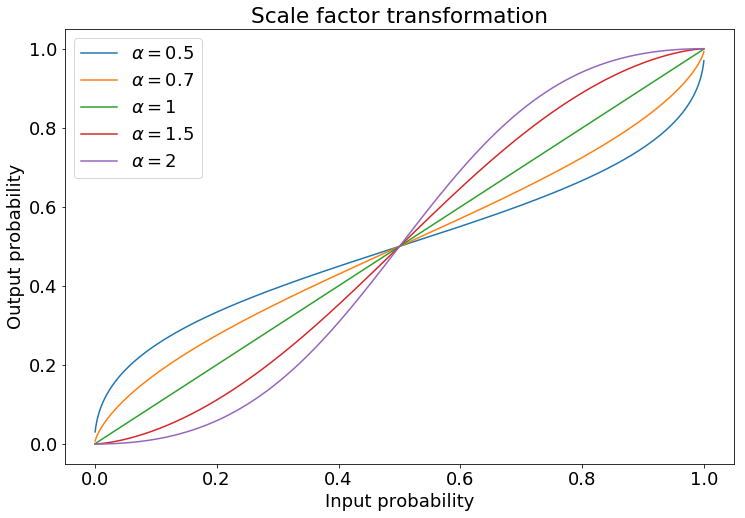

In [20]:
x=np.linspace(1/1000.,1-1/1000.,999)
# plt.plot()
for alpha in [0.5,0.7,1,1.5,2]:
    plt.plot(x,model.logit(alpha*model.logitInv(x)),label='$\\alpha = '+str(alpha)+'$')
plt.legend()
plt.xlabel('Input probability')
plt.ylabel('Output probability')
plt.title('Scale factor transformation')

Best scale factor:  0.481818181818


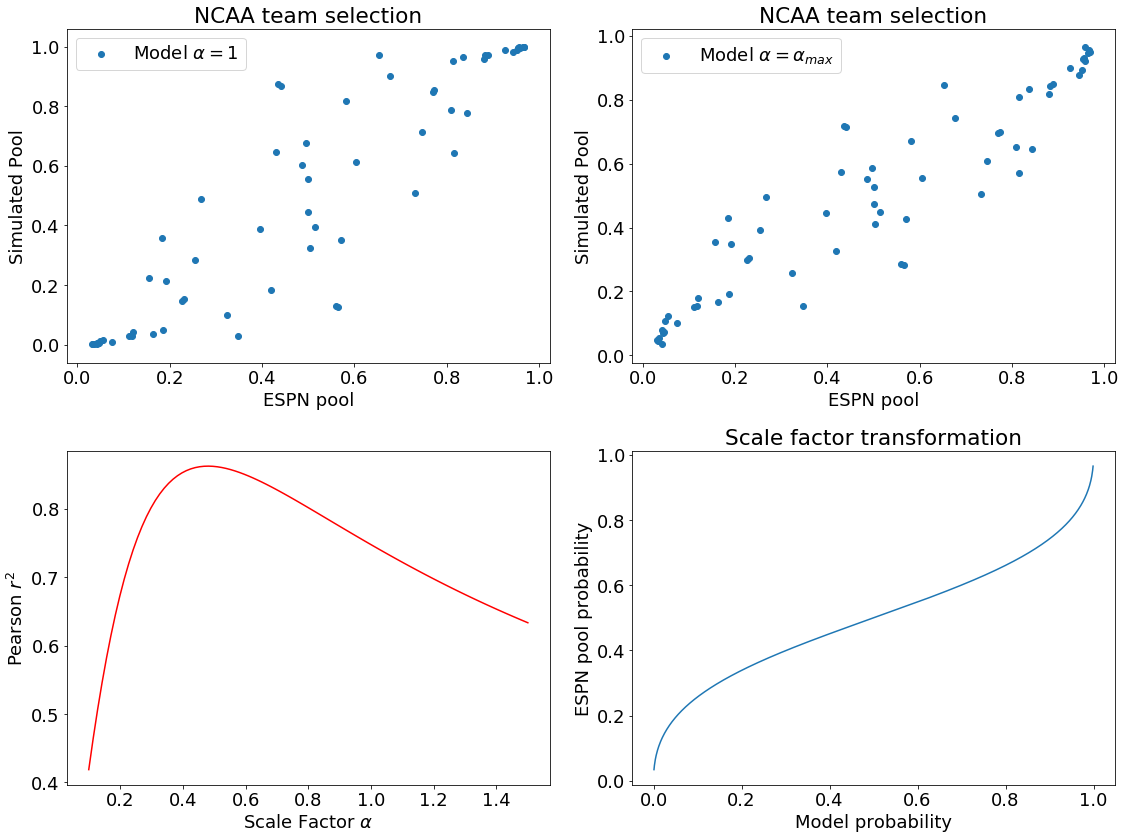

In [18]:
from sklearn.metrics import r2_score

scaleF=np.array([[scaleFactor,r2_score(df.prob,model.logit(scaleFactor*model.logitInv(df.probSim)))] for scaleFactor in np.linspace(0.1,1.5,100)])
indxMax=np.argmax(scaleF[:,1])

plt.subplot(2,2,1)
plt.scatter(df.prob,model.logit(1*model.logitInv(df.probSim)),label='Model $\\alpha = 1$')
plt.xlabel('ESPN pool')
plt.ylabel('Simulated Pool')
plt.title('NCAA team selection')
plt.legend()

scaleBest=scaleF[indxMax,0]
plt.subplot(2,2,2)
plt.scatter(df.prob,model.logit(scaleBest*model.logitInv(df.probSim)),label='Model $\\alpha = \\alpha_{max}$')
plt.xlabel('ESPN pool')
plt.ylabel('Simulated Pool')
plt.title('NCAA team selection')
plt.legend()

plt.subplot(2,2,3)
print('Best scale factor: ',scaleBest)

plt.plot(scaleF[:,0],scaleF[:,1],'r')
plt.xlabel('Scale Factor $\\alpha$')
plt.ylabel('Pearson $r^2$');
plt.title('')


plt.subplot(2,2,4)
plt.plot(x,model.logit(scaleBest*model.logitInv(x)),label='$\\alpha = '+str(scaleBest)+'$')
plt.xlabel('Model probability')
plt.ylabel('ESPN pool probability')
plt.title('Scale factor transformation')
plt.tight_layout()


In [15]:
x=[]
for tname in df.teamName:
    if tname in t.bracketOutcome[2]:
        x.append(1)
    else:
        x.append(0)
df['actual']=x

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df.actual.values>.5,df.prob.values>0.5)

array([[26,  6],
       [ 7, 25]])

In [17]:
confusion_matrix(df.actual.values>.5,df.probSim.values>0.5)

array([[28,  4],
       [ 4, 28]])

In [18]:
df[(df.prob>.5) & (df.probSim<0.5)]

,teamName,prob,probSim,actual
28,marquette,0.559,0.090317,0
27,maryland,0.565,0.079331,0
21,michigan,0.732,0.392822,1
29,michigan-state,0.514,0.380268,1
26,minnesota,0.571,0.237957,0
30,seton-hall,0.504,0.293723,0
